In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from time import time
from tqdm import tqdm


image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=image_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=image_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


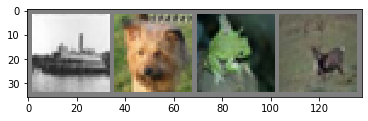

 ship   dog  frog  deer


In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


In [4]:
import torch.nn as nn
import torch.nn.functional as F


class ConvNet(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.conv1 = nn.Conv2d(3, 24, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(24, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    @staticmethod
    def reshape(x):
        return x.view(-1, 16 * 5 * 5)
        
    def forward(self, x):     # input: (batch, 3, 32, 32)
        for item in [
                self.conv1,   # (batch, 6, 28, 28)
                F.relu,
                self.pool,    # (batch, 6, 14, 14)
                self.conv2,   # (batch, 16, 10, 10)
                F.relu,
                self.pool,    # (batch, 16, 5, 5)
                self.reshape, # (batch, 400)
                self.fc1,     # (batch, 120)
                F.relu,
                self.fc2,     # (batch, 84)
                F.relu,
                self.fc3      # (batch, 10)
        ]:
            x = item(x)            
        return x
    
net = ConvNet()

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# cuda thing
gpu = True
if gpu:
    net.to(device)

for epoch in range(10):
    running_loss = 0.0
    for data in tqdm(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        if gpu:
            inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
    print('[%d] loss: %.3f' %
          (epoch + 1, running_loss / 2000))
    running_loss = 0.0

print('Finished Training')

  0%|          | 0/12500 [00:00<?, ?it/s]

[1] loss: 10.240


  0%|          | 0/12500 [00:00<?, ?it/s]

[2] loss: 7.801


  0%|          | 0/12500 [00:00<?, ?it/s]

[3] loss: 6.807


  0%|          | 0/12500 [00:00<?, ?it/s]

[4] loss: 6.126


  0%|          | 0/12500 [00:00<?, ?it/s]

[5] loss: 5.724


  0%|          | 0/12500 [00:00<?, ?it/s]

[6] loss: 5.365


  0%|          | 0/12500 [00:00<?, ?it/s]

[7] loss: 5.054


  0%|          | 0/12500 [00:00<?, ?it/s]

[8] loss: 4.790


  0%|          | 0/12500 [00:00<?, ?it/s]

[9] loss: 4.570


100%|██████████| 12500/12500 [00:34<00:00, 359.00it/s]

[10] loss: 4.403
Finished Training


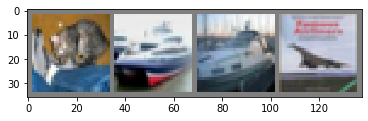

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship plane
Accuracy of the network on the 10000 test images: 67 %


In [6]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images, labels = images, labels

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = net(images.to(device)).cpu()

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))



correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        
        outputs = net(images.to(device)).cpu()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

In [7]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.to(device)).cpu()
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 75 %
Accuracy of   car : 84 %
Accuracy of  bird : 57 %
Accuracy of   cat : 46 %
Accuracy of  deer : 65 %
Accuracy of   dog : 51 %
Accuracy of  frog : 74 %
Accuracy of horse : 70 %
Accuracy of  ship : 73 %
Accuracy of truck : 77 %


In [8]:
from collections import defaultdict
import pandas as pd


confusion = {
    cls: [0.0 for _ in classes]
    for cls in classes
}
totals = {cls: 0.0 for cls in classes}
with torch.no_grad():
    for data in tqdm(testloader):
        images, labels = data
        outputs = net(images.to(device)).cpu()
        _, predicted = torch.max(outputs, 1)
        
        for c, l in zip(predicted.squeeze(), labels.squeeze()):
            c = c.item()
            l = l.item()
            
            confusion[classes[l]][c] += 1.0
            totals[classes[l]] += 1.0
            
confusion = {
    cls: [count / totals[cls] for count in confusion[cls]]
    for cls in confusion
}
            
df = pd.DataFrame(
    confusion,
    index=classes
)
df.style.background_gradient(cmap='viridis')

100%|██████████| 2500/2500 [00:07<00:00, 351.99it/s]


,plane,car,bird,cat,deer,dog,frog,horse,ship,truck
plane,0.753,0.016,0.094,0.032,0.027,0.015,0.012,0.028,0.1,0.028
car,0.017,0.846,0.01,0.023,0.004,0.01,0.008,0.01,0.045,0.114
bird,0.034,0.006,0.579,0.099,0.082,0.105,0.089,0.042,0.015,0.011
cat,0.02,0.006,0.051,0.462,0.058,0.194,0.057,0.039,0.011,0.021
deer,0.026,0.002,0.1,0.079,0.653,0.054,0.041,0.067,0.01,0.002
dog,0.001,0.003,0.061,0.16,0.037,0.514,0.023,0.072,0.003,0.002
frog,0.01,0.009,0.048,0.059,0.055,0.033,0.747,0.01,0.005,0.006
horse,0.013,0.005,0.022,0.035,0.067,0.047,0.008,0.7,0.007,0.014
ship,0.08,0.028,0.018,0.018,0.014,0.011,0.005,0.004,0.739,0.031
truck,0.046,0.079,0.017,0.033,0.003,0.017,0.01,0.028,0.065,0.771
